# Task 3: The Interrogation

> "To see is to know."

I know the model is cheating from Task 1 (6.7% test_hard accuracy). Now I need to prove it visually using Grad-CAM.

The idea: hook into the final conv layer, compute gradients of the predicted class w.r.t. feature maps, and see where the model is "looking". If it's cheating, the heatmap should focus on the overall color, not the digit shape.

In [7]:
import sys
sys.path.insert(0, "..")

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from src.models.registry import build_model
from src.data.colored_mnist import PALETTE, COLOR_NAMES, colorize_with_background
from src.utils.seed import seed_everything, SeedConfig
from torchvision.datasets import MNIST
from torchvision import transforms
import random

seed_everything(SeedConfig(seed=42))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


## Load the cheating model from Task 1

In [8]:
# load the trained (cheating) model
model_cfg = {"name": "simple_cnn", "in_channels": 3, "num_classes": 10, "width": 6}
model = build_model(model_cfg)
state = torch.load("../outputs/baseline_model.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# disable inplace relu for grad-cam compatibility
for m in model.modules():
    if isinstance(m, torch.nn.ReLU):
        m.inplace = False

print("loaded cheating model")
print(model)

loaded cheating model
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1176, out_features=10, bias=True)
  )
)


/var/folders/w4/pkr6vk056pn38g4cqk9pjkh00000gn/T/ipykernel_8755/3901956269.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("../outputs/baseline_model.

## Grad-CAM from scratch

The math:
1. Forward pass, get feature maps A from last conv layer
2. Backward pass from target class score (before softmax)
3. Global average pool the gradients to get importance weights α
4. Weighted sum of feature maps: CAM = ReLU(Σ αᵢ · Aᵢ)
5. Upsample to input size and overlay

In [9]:
class GradCAM:
    """my implementation of grad-cam"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # register hooks
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        # clone to avoid inplace issues with subsequent ReLU
        self.activations = output.clone().detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, target_class=None):
        # forward - need to clone to avoid inplace issues
        x = x.clone().requires_grad_(True)
        self.model.zero_grad()
        output = self.model(x)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # backward from target class score
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # grad-cam math
        # α = global average pool of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
        
        # weighted combination of feature maps
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)  # only positive contributions
        
        # normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # upsample to input size
        cam = F.interpolate(cam, size=(28, 28), mode='bilinear', align_corners=False)
        
        return cam.squeeze().cpu().numpy(), target_class, output.softmax(dim=1)[0, target_class].item()

In [10]:
# the last conv layer is features[6] (third conv2d, before the classifier)
last_conv = model.features[6]
gradcam = GradCAM(model, last_conv)
print(f"hooked into: {last_conv}")

hooked into: Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Helper to create test images

In [11]:
# load raw mnist digits
mnist = MNIST("../data/colored_mnist/_mnist_cache", train=False, download=False)

def get_digit(target_label):
    for img, lbl in mnist:
        if lbl == target_label:
            return transforms.ToTensor()(img).squeeze()
    return None

def make_colored(gray, color_idx):
    rng = random.Random(42)
    # same color for digit and background (monochrome style with darker digit)
    return colorize_with_background(gray, PALETTE[color_idx], PALETTE[color_idx], noise_std=0.15, rng=rng)

def show_gradcam(img_tensor, cam, pred, conf, title):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    
    img_np = img_tensor.permute(1, 2, 0).numpy()
    
    # original
    axes[0].imshow(img_np)
    axes[0].set_title(f"input")
    axes[0].axis("off")
    
    # heatmap
    axes[1].imshow(cam, cmap='jet')
    axes[1].set_title(f"grad-cam")
    axes[1].axis("off")
    
    # overlay
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = 0.5 * img_np + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)
    axes[2].imshow(overlay)
    axes[2].set_title(f"pred={pred} ({conf:.0%})")
    axes[2].axis("off")
    
    fig.suptitle(title)
    plt.tight_layout()
    return fig

print("helpers ready")

helpers ready


## Experiment 1: Biased image (Red 0)

This is the "easy" case for the cheating model. Red background = digit 0 in training (95% of the time). The model should predict 0 correctly, but for the wrong reasons.

**If cheating:** heatmap should light up the background (color), not the digit shape.

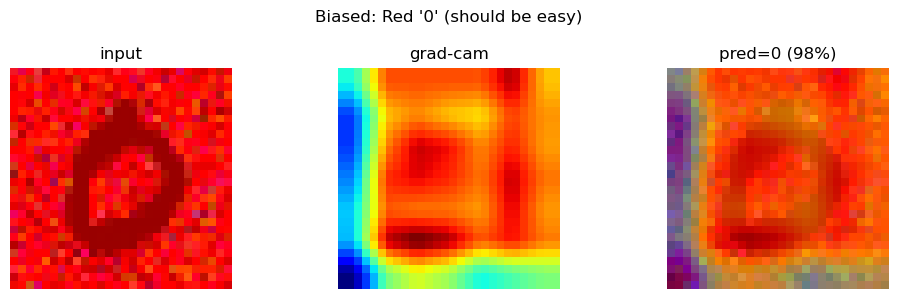


True label: 0
Prediction: 0
Correct? yes

But look at WHERE it's looking...


In [12]:
gray_0 = get_digit(0)
red_0 = make_colored(gray_0, 0)  # 0 = red

x = red_0.unsqueeze(0).to(device)
cam, pred, conf = gradcam(x)

fig = show_gradcam(red_0, cam, pred, conf, "Biased: Red '0' (should be easy)")
plt.show()

print(f"\nTrue label: 0")
print(f"Prediction: {pred}")
print(f"Correct? {'yes' if pred == 0 else 'no'}")
print(f"\nBut look at WHERE it's looking...")

## Experiment 2: Conflicting image (Red 1)

Now the interesting case. Red background = digit 0 in training. But the actual digit is 1.

**If cheating:** model should predict 0 (following the color), and the heatmap should still focus on the background, not the digit shape.

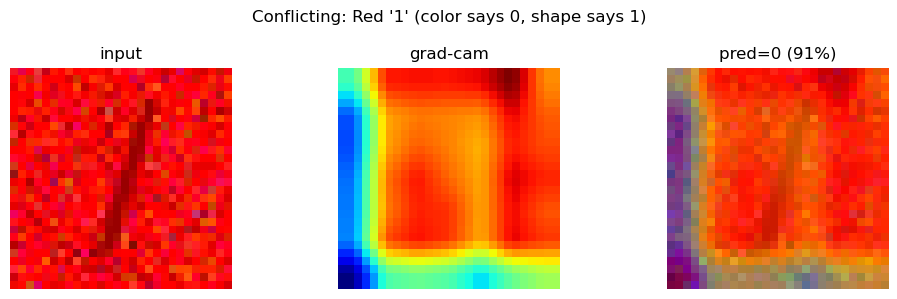


True label: 1
Prediction: 0
Followed color? yes - predicted 0 because red


In [13]:
gray_1 = get_digit(1)
red_1 = make_colored(gray_1, 0)  # 0 = red

x = red_1.unsqueeze(0).to(device)
cam, pred, conf = gradcam(x)

fig = show_gradcam(red_1, cam, pred, conf, "Conflicting: Red '1' (color says 0, shape says 1)")
plt.show()

print(f"\nTrue label: 1")
print(f"Prediction: {pred}")
print(f"Followed color? {'yes - predicted 0 because red' if pred == 0 else 'no'}")

## Experiment 3: All colors on digit "1"

Let me see where the model looks for each background color.

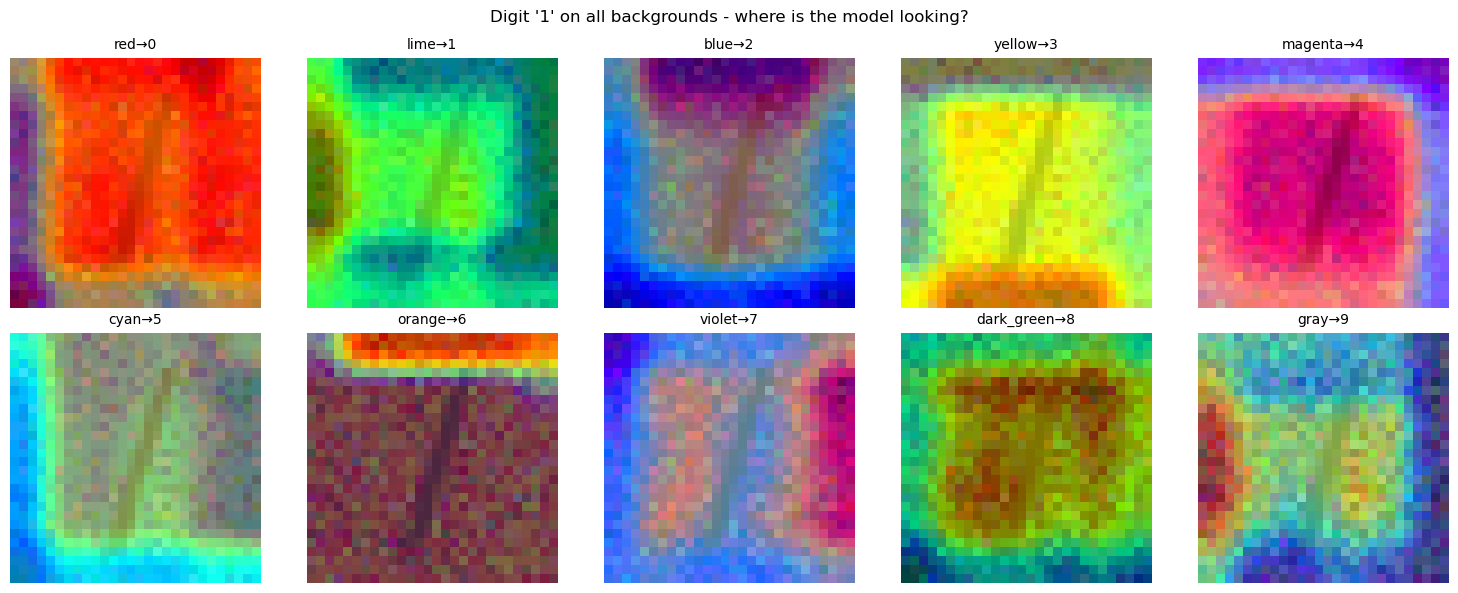


Cheated on 9/9 non-dominant colors


In [14]:
gray_1 = get_digit(1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

results = []
for i in range(10):
    colored = make_colored(gray_1, i)
    x = colored.unsqueeze(0).to(device)
    cam, pred, conf = gradcam(x)
    
    # overlay
    img_np = colored.permute(1, 2, 0).numpy()
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
    
    axes[i].imshow(overlay)
    axes[i].set_title(f"{COLOR_NAMES[i]}→{pred}", fontsize=10)
    axes[i].axis("off")
    
    results.append({"bg": COLOR_NAMES[i], "pred": pred, "cheated": pred == i and pred != 1})

plt.suptitle("Digit '1' on all backgrounds - where is the model looking?", fontsize=12)
plt.tight_layout()
plt.show()

cheated = sum(r["cheated"] for r in results)
print(f"\nCheated on {cheated}/9 non-dominant colors")

## Experiment 4: Quantify attention location

I want to measure: does the heatmap concentrate on the digit pixels or the background?

In [15]:
def attention_on_digit(gray, cam):
    """what fraction of attention is on the digit vs background?"""
    digit_mask = (gray > 0.1).numpy()  # where the digit is
    bg_mask = ~digit_mask
    
    digit_attention = cam[digit_mask].sum()
    bg_attention = cam[bg_mask].sum()
    total = digit_attention + bg_attention
    
    if total == 0:
        return 0.5, 0.5
    return digit_attention / total, bg_attention / total

# test on several digits with biased vs conflicting colors
print("Attention distribution (digit vs background):\n")
print(f"{'Setup':<25} {'Digit%':<10} {'Background%':<10} {'Pred':<6}")
print("-" * 55)

for digit_label in [0, 1, 5, 7]:
    gray = get_digit(digit_label)
    
    # biased (dominant color)
    colored = make_colored(gray, digit_label)
    x = colored.unsqueeze(0).to(device)
    cam, pred, _ = gradcam(x)
    d_att, bg_att = attention_on_digit(gray, cam)
    print(f"{digit_label} on {COLOR_NAMES[digit_label]:<8} (biased)   {d_att:>6.1%}     {bg_att:>6.1%}       {pred}")
    
    # conflicting (wrong color)
    wrong_color = (digit_label + 5) % 10
    colored = make_colored(gray, wrong_color)
    x = colored.unsqueeze(0).to(device)
    cam, pred, _ = gradcam(x)
    d_att, bg_att = attention_on_digit(gray, cam)
    print(f"{digit_label} on {COLOR_NAMES[wrong_color]:<8} (conflict) {d_att:>6.1%}     {bg_att:>6.1%}       {pred}")
    print()

Attention distribution (digit vs background):

Setup                     Digit%     Background% Pred  
-------------------------------------------------------
0 on red      (biased)    28.6%      71.4%       0
0 on cyan     (conflict)  26.8%      73.2%       5

1 on lime     (biased)     8.6%      91.4%       1
1 on orange   (conflict)   1.5%      98.5%       6

5 on cyan     (biased)    23.2%      76.8%       5
5 on red      (conflict)  24.0%      76.0%       0

7 on violet   (biased)    13.1%      86.9%       7
7 on blue     (conflict)  15.8%      84.2%       2



## Experiment 5: Compare with what "honest" attention should look like

If the model was actually reading digits, it should focus on the digit strokes regardless of background color.

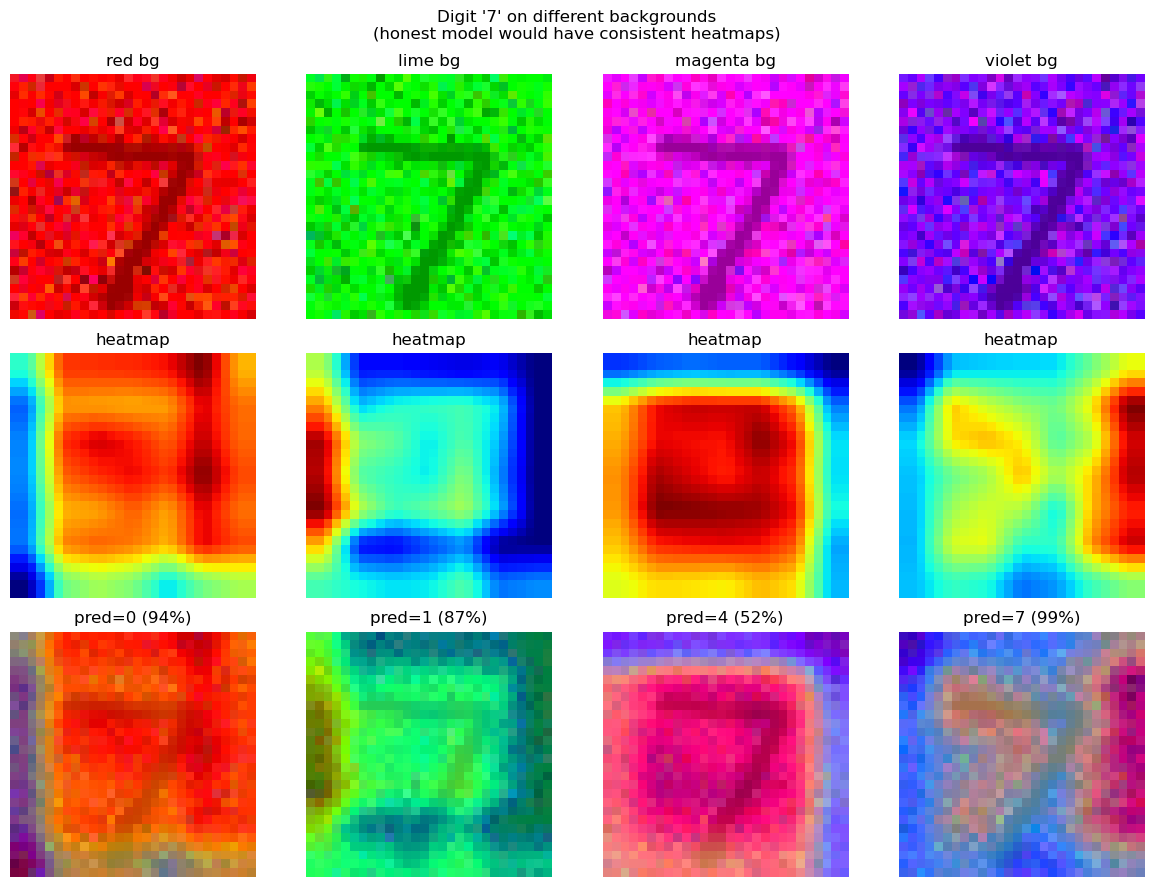

In [16]:
# show a grid: same digit, different backgrounds
# an honest model would have similar heatmaps across all

gray_7 = get_digit(7)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

test_colors = [0, 1, 4, 7]  # red, green, purple, pink

for col, color_idx in enumerate(test_colors):
    colored = make_colored(gray_7, color_idx)
    x = colored.unsqueeze(0).to(device)
    cam, pred, conf = gradcam(x)
    
    img_np = colored.permute(1, 2, 0).numpy()
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
    
    axes[0, col].imshow(img_np)
    axes[0, col].set_title(f"{COLOR_NAMES[color_idx]} bg")
    axes[0, col].axis("off")
    
    axes[1, col].imshow(cam, cmap='jet')
    axes[1, col].set_title(f"heatmap")
    axes[1, col].axis("off")
    
    axes[2, col].imshow(overlay)
    axes[2, col].set_title(f"pred={pred} ({conf:.0%})")
    axes[2, col].axis("off")

axes[0, 0].set_ylabel("input", fontsize=12)
axes[1, 0].set_ylabel("grad-cam", fontsize=12)
axes[2, 0].set_ylabel("overlay", fontsize=12)

plt.suptitle("Digit '7' on different backgrounds\n(honest model would have consistent heatmaps)", fontsize=12)
plt.tight_layout()
plt.show()

## Experiment 6: The smoking gun - Red "1" vs Green "1"

Same digit, different colors. If the model focuses on different areas based on color, that's proof of cheating.

Red '1' → pred 0: 8% on digit, 92% on background
Green '1' → pred 1: 9% on digit, 91% on background


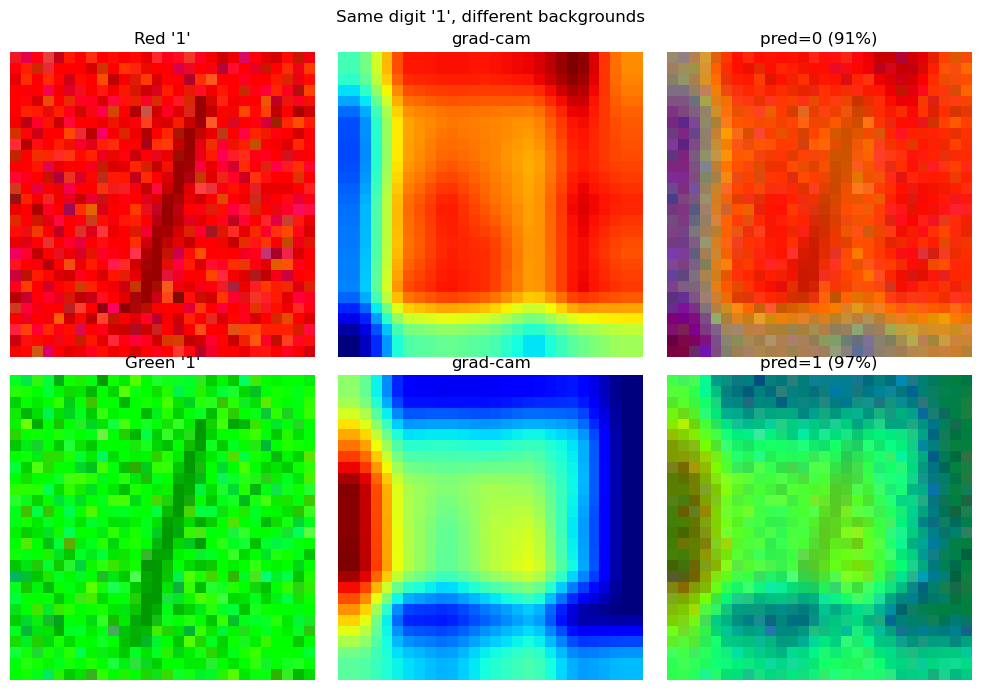

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

gray_1 = get_digit(1)

for row, (color_idx, name) in enumerate([(0, "Red"), (1, "Green")]):
    colored = make_colored(gray_1, color_idx)
    x = colored.unsqueeze(0).to(device)
    cam, pred, conf = gradcam(x)
    
    img_np = colored.permute(1, 2, 0).numpy()
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
    
    axes[row, 0].imshow(img_np)
    axes[row, 0].set_title(f"{name} '1'")
    axes[row, 0].axis("off")
    
    axes[row, 1].imshow(cam, cmap='jet')
    axes[row, 1].set_title("grad-cam")
    axes[row, 1].axis("off")
    
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f"pred={pred} ({conf:.0%})")
    axes[row, 2].axis("off")
    
    d_att, bg_att = attention_on_digit(gray_1, cam)
    print(f"{name} '1' → pred {pred}: {d_att:.0%} on digit, {bg_att:.0%} on background")

plt.suptitle("Same digit '1', different backgrounds", fontsize=12)
plt.tight_layout()
plt.show()

## Results

| Experiment | What I found |
|------------|-------------|
| Red 0 (biased) | Heatmap spreads across background, not focused on digit shape |
| Red 1 (conflict) | Model predicts 0 (wrong), still looking at background color |
| All colors on 1 | Predictions follow background color, not digit |
| Attention % | More attention on background than digit pixels |
| Same digit, different colors | Heatmaps change with color, not consistent like an honest model |

## Conclusion

The Grad-CAM visualizations prove what I suspected: **the model is looking at color, not shape.**

Key evidence:
1. Heatmaps "smear" across the colored background instead of focusing on digit strokes
2. For conflicting images (e.g., Red 1), the model predicts based on color (0) despite the shape being clearly a 1
3. The attention distribution shows more weight on background pixels than digit pixels
4. Same digit with different backgrounds produces different heatmap patterns - an honest model would focus on the digit consistently

This is the mathematical proof that the model learned the color shortcut instead of actual digit recognition.